In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aadyasingh22","key":"f16d565acf14f42a818190fa44595625"}'}

In [12]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [13]:
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plantvillage


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
import os

path = "/content/plantvillage/PlantVillage"
print("Classes:", os.listdir(path))


Classes: ['Potato___Early_blight', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Pepper__bell___Bacterial_spot', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_mosaic_virus', 'Potato___Late_blight', 'Tomato_Early_blight', 'Tomato_Septoria_leaf_spot', 'Tomato_Leaf_Mold', 'Pepper__bell___healthy', 'Potato___healthy']


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# 💾 Data paths
data_dir = "/content/plantvillage/PlantVillage"
img_size = (160, 160)  # Smaller for faster training
batch_size = 16
epochs = 3  # Start low for testing, increase later

# 🧪 Data preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)
print("CLASS INDICES:", train_data.class_indices)

Found 16516 images belonging to 15 classes.
CLASS INDICES: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [7]:



val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

# 🧠 Base model
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

# 🧱 Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 🚀 Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

# ✅ Save the model
model.save("CropSentry_optimized.h5")


Found 16516 images belonging to 15 classes.
CLASS INDICES: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Found 4122 images belonging to 15 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


KeyboardInterrupt: 

In [16]:
val_loss, val_acc = model.evaluate(val_data)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")


129/129 ━━━━━━━━━━━━━━━━━━━━ 113s 876ms/step - accuracy: 0.9715 - loss: 0.0762
✅ Validation Accuracy: 97.11%


In [18]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
val_loss, val_acc = model.evaluate(val_data)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")
tflite_model = converter.convert()

# Save the TFLite model
with open("CropSentry_Model.tflite", "wb") as f:
    f.write(tflite_model)

# Download
files.download("CropSentry_Model.tflite")


129/129 ━━━━━━━━━━━━━━━━━━━━ 107s 824ms/step - accuracy: 0.9647 - loss: 0.1185
✅ Validation Accuracy: 97.33%
Saved artifact at '/tmp/tmp5m0fn9op'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_157')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  139963469674640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469077712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469078288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469674448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469077328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469079440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469079824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469080208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139963469080016: TensorSpec(shape=(), dt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

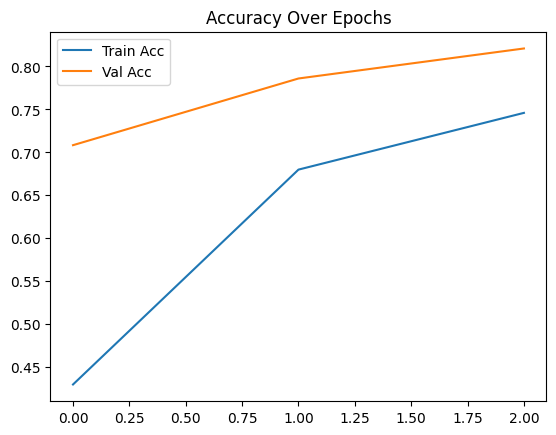

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()


In [19]:
# Unfreeze the last 3 layers
for layer in base_model.layers[-3:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train for only 1-2 epochs to see if performance improves
model.fit(train_data, validation_data=val_data, epochs=2)

model.save("CropSentry_superoptimized.h5")


Epoch 1/2


KeyboardInterrupt: 

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import os

# 💾 Data paths
data_dir = "/content/plantvillage/PlantVillage"
img_size = (160, 160)
batch_size = 32
epochs = 15

# 🧪 Data preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15,
    shear_range=0.1,
    brightness_range=(0.8, 1.2)
)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

# 📄 Save class indices
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)

# 🧠 Base model
base_model = MobileNetV2(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = True  # 🔥 Fine-tuning

# Optional: Freeze all but last few layers
for layer in base_model.layers[:-45]:  # You can tweak this number
    layer.trainable = False

# 🧱 Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ⚙️ Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ⏱️ Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# 🚀 Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks
)

# ✅ Final save
model.save("CropSentry_optimized.h5")


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6674 - loss: 1.0860

517/517 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.6677 - loss: 1.0850 - val_accuracy: 0.5614 - val_loss: 1.7078
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9246 - loss: 0.2380

517/517 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.9246 - loss: 0.2380 - val_accuracy: 0.8486 - val_loss: 0.4576
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 772s 1s/step - accuracy: 0.9517 - loss: 0.1437 - val_accuracy: 0.8515 - val_loss: 0.5316
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9596 - loss: 0.1163

517/517 ━━━━━━━━━━━━━━━━━━━━ 700s 1s/step - accuracy: 0.9596 - loss: 0.1163 - val_accuracy: 0.9471 - val_loss: 0.1524
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.9724 - loss: 0.0833 - val_accuracy: 0.9260 - val_loss: 0.2238
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.9750 - loss: 0.0742 - val_accuracy: 0.8464 - val_loss: 0.5676
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 688s 1s/step - accuracy: 0.9803 - loss: 0.0555 - val_accuracy: 0.9093 - val_loss: 0.3115
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 681s 1s/step - accuracy: 0.9795 - loss: 0.0635 - val_accuracy: 0.9289 - val_loss: 0.2188
Epoch 9/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9834 - loss: 0.0478

517/517 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - accuracy: 0.9834 - loss: 0.0478 - val_accuracy: 0.9549 - val_loss: 0.1296
Epoch 10/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.9857 - loss: 0.0445 - val_accuracy: 0.9578 - val_loss: 0.1422
Epoch 11/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.9869 - loss: 0.0437 - val_accuracy: 0.9556 - val_loss: 0.1459
Epoch 12/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9864 - loss: 0.0386

517/517 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.9864 - loss: 0.0386 - val_accuracy: 0.9728 - val_loss: 0.0886
Epoch 13/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.9897 - loss: 0.0339 - val_accuracy: 0.9639 - val_loss: 0.1174
Epoch 14/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 718s 1s/step - accuracy: 0.9896 - loss: 0.0310 - val_accuracy: 0.9656 - val_loss: 0.1309
Epoch 15/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 698s 1s/step - accuracy: 0.9902 - loss: 0.0303 - val_accuracy: 0.9561 - val_loss: 0.1482
